# JupyterLite で学ぶ statsmodels 入門チュートリアル

JupyterLite（ブラウザだけで動く Jupyter 環境）上で、`statsmodels` を用いた基本的な統計モデリング（回帰分析・検定など）を体験するためのノートブックです。

## 0. 環境準備（JupyterLite 用）

このノートブックは **JupyterLite（Pyodide）** 上で動かすことを想定しています。

まず、必要なパッケージをインストール（またはロード）します。

環境によってはすでにインストール済みの場合もありますが、
エラーが出た場合は、次のセルを上から順に実行して確認してください。

In [1]:
# 必要に応じて piplite / micropip を利用してパッケージをインストールします。
# すでにインストール済みの環境では、このセルはスキップまたは実行しても何も起こらない場合があります。

try:
    import piplite
    # JupyterLite サイト側で wheel が用意されている場合はこちらでロード
    await piplite.install(["numpy", "pandas", "matplotlib", "seaborn", "statsmodels", "scipy", "japanize-matplotlib-jlite"])
except ImportError:
    # piplite がない環境（通常のローカル Jupyter など）の場合はそのまま進みます。
    pass

# 必要に応じて micropip を使って純 Python パッケージを追加することもできます。
# import micropip
# await micropip.install("some-pure-python-package")


### 0.1 インポートと日本語表示設定

グラフ描画や統計モデリングに必要なライブラリをインポートし、
日本語が文字化けしないように `japanize_matplotlib_jlite` を最後に読み込みます。

In [2]:
import matplotlib.pyplot as plt  # グラフ作成の基本ライブラリ
import seaborn as sns           # きれいなグラフを簡単に作成できるライブラリ
import numpy as np              # 数値計算用ライブラリ（配列や数学関数）
import pandas as pd             # データ分析用ライブラリ（表形式のデータ処理）
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

import japanize_matplotlib_jlite  # 必ず最後に読み込む

# グラフのスタイル設定（お好みで調整可）
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


## 1. 単回帰分析の基本

まず、もっとも基本的な **単回帰分析**（説明変数が 1 つの線形回帰）から始めます。
ここでは、架空データとして「身長から体重を予測する」モデルを作ってみます。

### 1.1 ダミーデータの作成

NumPy を使って身長と体重のダミーデータを生成し、Pandas の DataFrame にまとめます。

In [3]:
# 乱数の再現性のためのシード
np.random.seed(42)

# 身長（cm）: 平均 165, 標準偏差 10 の正規分布から 100 人分
height = np.random.normal(loc=165, scale=10, size=100)

# 体重（kg）: 身長にほぼ比例 + ノイズ
true_intercept = -60
true_slope = 0.8
weight = true_intercept + true_slope * height + np.random.normal(loc=0, scale=3, size=100)

# DataFrame にまとめる
df = pd.DataFrame({
    "height": height,
    "weight": weight
})

df.head()


,height,weight
0,169.967142,71.727601
1,163.617357,69.631950
2,171.476885,76.153365
3,180.230299,81.777407
4,162.658466,69.642916


### 1.2 散布図の確認

まずは **散布図** で身長と体重の関係を視覚的に確認します。

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36523 (\N{CJK UNIFIED IDEOGRAPH-8EAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38263 (\N{CJK UNIFIED IDEOGRAPH-9577}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/

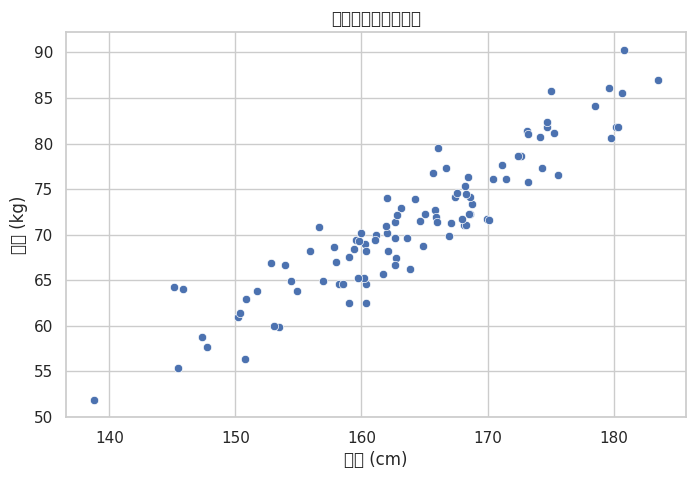

In [4]:
sns.scatterplot(data=df, x="height", y="weight")
plt.title("身長と体重の散布図")
plt.xlabel("身長 (cm)")
plt.ylabel("体重 (kg)")
plt.show()


### 1.3 statsmodels による単回帰モデル

`statsmodels.formula.api` の `ols`（ordinary least squares）を用いて、
次のようなモデルを推定します。

$$ \text{weight} = \beta_0 + \beta_1 \cdot \text{height} + \varepsilon $$

フォーミュラ表記では、

`weight ~ height`

と書きます。

In [5]:
# フォーミュラ形式での単回帰モデル
model = smf.ols("weight ~ height", data=df)
result = model.fit()

# 回帰結果のサマリーを表示
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     576.6
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           7.66e-43
Time:                        09:30:56   Log-Likelihood:                -245.57
No. Observations:                 100   AIC:                             495.1
Df Residuals:                      98   BIC:                             500.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -52.8865      5.177    -10.216      0.000     -63.160     -42.613
height         0.7570      0.032     24.013      0.000       0.694       0.820
==============================================================================
Omnibus:                        1.950   Durbin-Watson:                   2.194
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                1.909
Skew:                           0.327   Prob(JB):                        0.385
Kurtosis:                       2.829   Cond. No.                     2.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 1.4 推定された係数の解釈

推定された回帰係数（切片と傾き）を取り出して確認します。

In [6]:
print("推定された係数:")
print(result.params)
print("\n95% 信頼区間:")
print(result.conf_int())


推定された係数:
Intercept   -52.886487
height        0.757023
dtype: float64

95% 信頼区間:
                   0          1
Intercept -63.159659 -42.613315
height      0.694462   0.819584


### 1.5 回帰直線の描画

散布図の上に、推定された回帰直線を重ねて描画します。

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36523 (\N{CJK UNIFIED IDEOGRAPH-8EAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38263 (\N{CJK UNIFIED IDEOGRAPH-9577}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/s

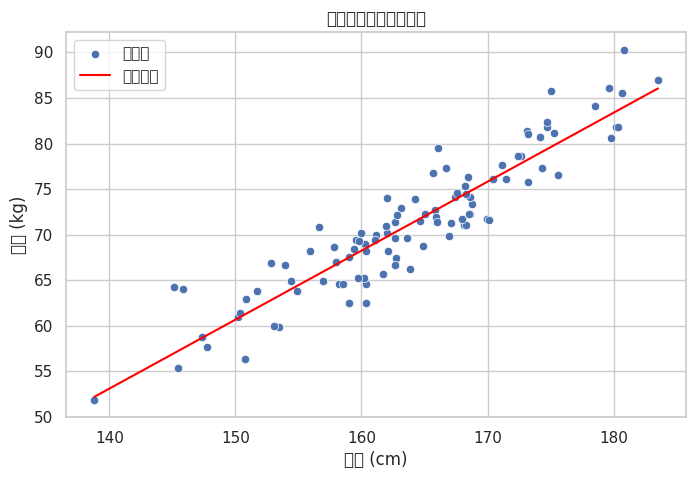

In [7]:
# 散布図
sns.scatterplot(data=df, x="height", y="weight", label="観測値")

# 回帰直線用の x の範囲
x_pred = np.linspace(df["height"].min(), df["height"].max(), 100)
X_pred = pd.DataFrame({"height": x_pred})

# 予測値
y_pred = result.predict(X_pred)

plt.plot(x_pred, y_pred, color="red", label="回帰直線")
plt.title("身長と体重の回帰直線")
plt.xlabel("身長 (cm)")
plt.ylabel("体重 (kg)")
plt.legend()
plt.show()


## 2. 残差解析とモデルのチェック

回帰分析では、**残差（予測値と実測値の差）** を調べることで、
モデルがデータにどの程度適合しているか、仮定がどれくらい満たされているかを確認します。

### 2.1 残差の計算

In [8]:
# 残差（実測値 - 予測値）
df["fitted"] = result.fittedvalues
df["resid"] = result.resid

df[["height", "weight", "fitted", "resid"]].head()


,height,weight,fitted,resid
0,169.967142,71.727601,75.782523,-4.054922
1,163.617357,69.631950,70.975591,-1.343642
2,171.476885,76.153365,76.925434,-0.772069
3,180.230299,81.777407,83.551968,-1.774561
4,162.658466,69.642916,70.249689,-0.606773


### 2.2 残差 vs 予測値のプロット

理想的には、残差は 0 を中心にランダムに散らばっていることが望ましいです。

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20104 (\N{CJK UNIFIED IDEOGRAPH-4E88}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28204 (\N{CJK UNIFIED IDEOGRAPH-6E2C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/

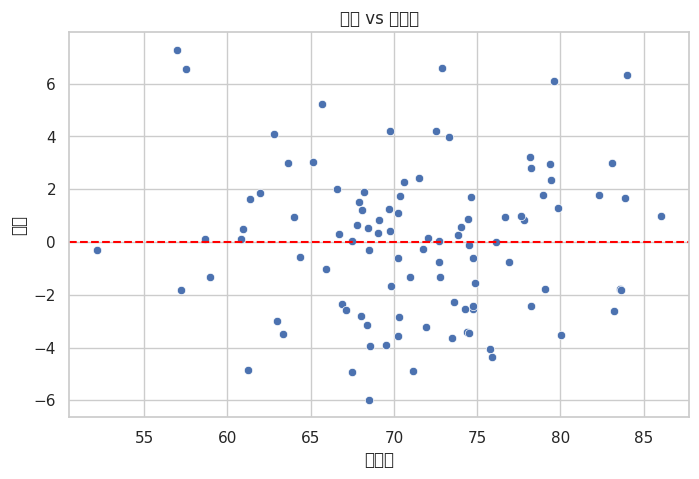

In [9]:
sns.scatterplot(x=df["fitted"], y=df["resid"])
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("予測値")
plt.ylabel("残差")
plt.title("残差 vs 予測値")
plt.show()


### 2.3 残差の正規性のチェック（Q-Q プロット）

線形回帰モデルでは、誤差項（残差）が正規分布に従うという仮定を置きます。
Q-Q プロットを用いて、残差の正規性を視覚的に確認します。

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12525 (\N{KATAKANA LETTER RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packag

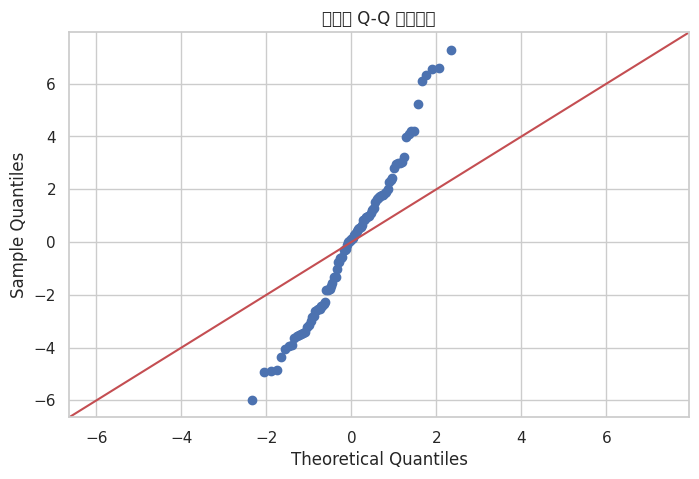

In [10]:
sm.qqplot(df["resid"], line="45")
plt.title("残差の Q-Q プロット")
plt.show()


## 3. 信頼区間と予測区間

`statsmodels` では、回帰直線に対する **信頼帯** や、
新しい観測値の **予測区間** を計算することができます。

### 3.1 予測と区間推定

In [11]:
# 予測したい身長の値
new_height = pd.DataFrame({"height": np.linspace(150, 180, 50)})

# 予測と信頼区間・予測区間
pred = result.get_prediction(new_height)
pred_summary = pred.summary_frame(alpha=0.05)  # 95% 信頼水準

pred_summary.head()


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,60.666941,0.524285,59.626513,61.707368,54.918878,66.415004
1,61.130424,0.508190,60.121937,62.138911,55.388056,66.872792
2,61.593907,0.492325,60.616904,62.570911,55.856985,67.330830
3,62.057391,0.476714,61.111367,63.003414,56.325663,67.789118
4,62.520874,0.461382,61.605276,63.436472,56.794090,68.247659


### 3.2 回帰直線と信頼帯・予測帯の可視化

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 36523 (\N{CJK UNIFIED IDEOGRAPH-8EAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38263 (\N{CJK UNIFIED IDEOGRAPH-9577}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/

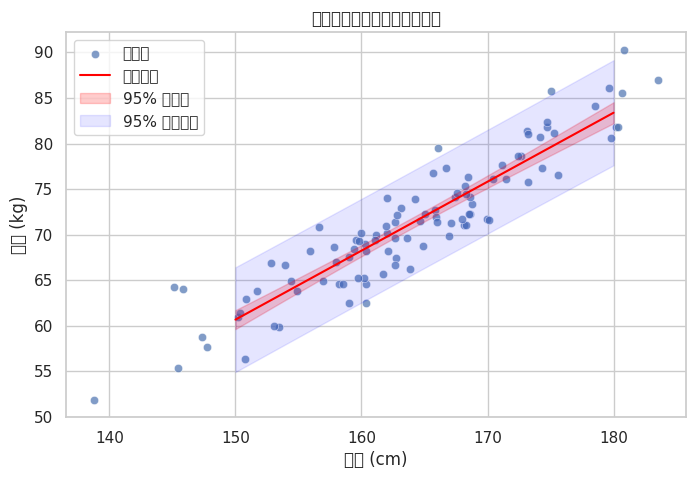

In [12]:
# 回帰直線・信頼帯・予測帯をまとめて可視化
plt.figure(figsize=(8, 5))

# 元データの散布図
sns.scatterplot(data=df, x="height", y="weight", label="観測値", alpha=0.7)

# 回帰直線
plt.plot(new_height["height"], pred_summary["mean"], color="red", label="回帰直線")

# 信頼帯（mean_ci_lower, mean_ci_upper）
plt.fill_between(new_height["height"],
                 pred_summary["mean_ci_lower"],
                 pred_summary["mean_ci_upper"],
                 color="red", alpha=0.2, label="95% 信頼帯")

# 予測区間（obs_ci_lower, obs_ci_upper）
plt.fill_between(new_height["height"],
                 pred_summary["obs_ci_lower"],
                 pred_summary["obs_ci_upper"],
                 color="blue", alpha=0.1, label="95% 予測区間")

plt.xlabel("身長 (cm)")
plt.ylabel("体重 (kg)")
plt.title("回帰直線と信頼帯・予測区間")
plt.legend()
plt.show()


## 4. t検定・分散分析（ANOVA）の例

ここでは、`statsmodels` と `scipy.stats` を併用して、
**2群の平均差の検定（t検定）** と、
**3群以上の平均差の検定（分散分析：ANOVA）** を簡単に体験します。

### 4.1 2群の t検定（scipy.stats.ttest_ind）

例として、「従来の学習法」と「新しい学習法」のテスト得点を比較します。

In [13]:
np.random.seed(0)

# 従来の学習法グループ（平均 70, 標準偏差 10）
traditional = np.random.normal(loc=70, scale=10, size=30)

# 新しい学習法グループ（平均 75, 標準偏差 10）
new_method = np.random.normal(loc=75, scale=10, size=30)

# 対応のない t検定
t_stat, p_value = stats.ttest_ind(new_method, traditional)

print("=== t検定の結果 ===")
print(f"従来法の平均: {traditional.mean():.2f}")
print(f"新しい学習法の平均: {new_method.mean():.2f}")
print(f"t値: {t_stat:.3f}")
print(f"p値: {p_value:.4f}")


=== t検定の結果 ===
従来法の平均: 74.43
新しい学習法の平均: 72.10
t値: -0.890
p値: 0.3773


### 4.2 1要因分散分析（one-way ANOVA）

`statsmodels` の `ols` と `anova_lm` を用いて、
3つのグループの平均に差があるかどうかを検定します。

In [14]:
from statsmodels.stats.anova import anova_lm

np.random.seed(1)

# 3つのグループのダミーデータ（平均の異なる正規分布）
group_A = np.random.normal(loc=65, scale=8, size=30)
group_B = np.random.normal(loc=70, scale=8, size=30)
group_C = np.random.normal(loc=75, scale=8, size=30)

score = np.concatenate([group_A, group_B, group_C])
group = (["A"] * 30) + (["B"] * 30) + (["C"] * 30)

df_anova = pd.DataFrame({"score": score, "group": group})

# フォーミュラ形式での ANOVA モデル
model_anova = smf.ols("score ~ C(group)", data=df_anova).fit()
anova_table = anova_lm(model_anova)

anova_table


,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,2085.504642,1042.752321,19.044099,1.380946e-07
Residual,87.0,4763.651464,54.754615,NaN,NaN


### 4.3 グループごとの分布の可視化

箱ひげ図を使って、各グループの分布を視覚的に比較します。

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24471 (\N{CJK UNIFIED IDEOGRAPH-5F97}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/pyth

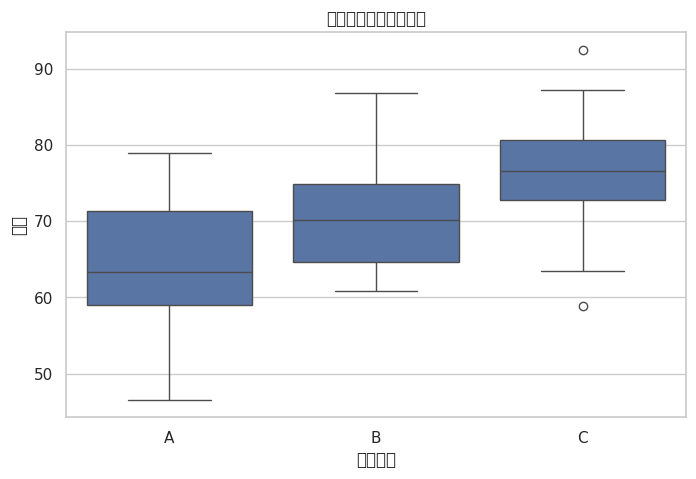

In [15]:
sns.boxplot(data=df_anova, x="group", y="score")
plt.xlabel("グループ")
plt.ylabel("得点")
plt.title("グループ別得点の分布")
plt.show()


## 5. 総合ミニ演習

最後に、これまでの内容を組み合わせた **ミニ演習** を行います。
自分でコードを書き換えたり、条件を変えてみたりしながら理解を深めてください。

### 演習 1：別の説明変数を追加した重回帰モデル

1. 身長に加えて、例えば「年齢」や「性別」をダミー変数として追加したダミーデータを作成し、
2. `weight ~ height + age` または `weight ~ height + C(sex)` のような **重回帰モデル** を推定してみましょう。
3. 係数の解釈や、単回帰モデルとの違いをコメントしてみてください。

### 演習 2：残差の正規性が崩れるケースを作ってみる

1. わざと外れ値（非常に大きな体重など）をいくつか追加したデータを作成し、
2. Q-Q プロットや残差プロットを確認してみましょう。
3. モデルの仮定が崩れると、どのような問題が生じそうかコメントしてみてください。

### 演習 3：オリジナルデータでの statsmodels 利用

1. 自分で集めた小さなデータ（例：学習時間とテスト得点）を DataFrame にまとめ、
2. `statsmodels` を使って単回帰・重回帰モデルを推定してみましょう。
3. 係数や p値、決定係数（R^2）などを確認し、結果をレポート風にまとめてみてください。

---

これで、JupyterLite 上での `statsmodels` の基本的な使い方のチュートリアルは終了です。

より高度なモデル（ロジスティック回帰、時系列解析、パネルデータ分析など）も、
基本的な流れは同じですので、公式ドキュメントや教科書と併せて試してみてください。

## 6. ロジスティック回帰（Logistic Regression）

ここでは、目的変数が 0/1 の **二値データ** のときに用いられる、
**ロジスティック回帰モデル** を `statsmodels` で実行してみます。

例として、「学習時間」と「予備校受講の有無」から、
テストに **合格（1）するか不合格（0）か** を予測するモデルを考えます。

### 6.1 ダミーデータの作成

次のような前提でデータを生成します。

- `study_hours`: 1日あたりの平均学習時間（連続変数）
- `prep_course`: 予備校受講の有無（0: 受講無し, 1: 受講あり）
- `passed`: テスト合否（0: 不合格, 1: 合格）

ロジットモデルの真の生成過程は以下のように設定します。

$$ \text{logit}(p) = -3 + 0.6 \cdot \text{study\_hours} + 1.0 \cdot \text{prep\_course} $$

ここで $p$ は合格する確率です。

In [16]:
np.random.seed(123)

n = 200

# 学習時間（平均5時間、標準偏差2時間くらい）
study_hours = np.clip(np.random.normal(loc=5, scale=2, size=n), 0, None)

# 予備校受講（40%が受講）
prep_course = np.random.binomial(1, 0.4, size=n)

# ロジットモデルに基づく合格確率
logit_p = -3 + 0.6 * study_hours + 1.0 * prep_course
p = 1 / (1 + np.exp(-logit_p))

# 合格フラグ（0/1）
passed = np.random.binomial(1, p, size=n)

df_logit = pd.DataFrame({
    "study_hours": study_hours,
    "prep_course": prep_course,
    "passed": passed
})

df_logit.head()


,study_hours,prep_course,passed
0,2.828739,0,0
1,6.994691,1,1
2,5.565957,1,1
3,1.987411,0,0
4,3.842799,0,1


### 6.2 合格率と学習時間の関係をざっくり確認

学習時間をいくつかの区間に分けて、各区間での平均合格率を見てみます。

In [17]:
# 学習時間をビン分割して合格率を集計
df_logit["hours_bin"] = pd.cut(df_logit["study_hours"], bins=[0,2,4,6,8,10])
agg = df_logit.groupby("hours_bin")["passed"].mean()

print("学習時間区間ごとの合格率:")
print(agg)


学習時間区間ごとの合格率:
hours_bin
(0, 2]     0.090909
(2, 4]     0.387755
(4, 6]     0.538462
(6, 8]     0.790698
(8, 10]    0.933333
Name: passed, dtype: float64


/tmp/ipykernel_5676/1699160484.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_logit.groupby("hours_bin")["passed"].mean()


### 6.3 statsmodels によるロジスティック回帰

`statsmodels.formula.api` の `logit` を使います。

フォーミュラ表記：

`passed ~ study_hours + C(prep_course)`

`C(prep_course)` と書くことで、カテゴリ（ダミー）変数として扱うことができます。

In [18]:
# ロジスティック回帰モデル
logit_model = smf.logit("passed ~ study_hours + C(prep_course)", data=df_logit)
logit_result = logit_model.fit()

logit_result.summary()


Optimization terminated successfully.
         Current function value: 0.547195
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 passed   No. Observations:                  200
Model:                          Logit   Df Residuals:                      197
Method:                           MLE   Df Model:                            2
Date:                Mon, 08 Dec 2025   Pseudo R-squ.:                  0.2036
Time:                        09:30:57   Log-Likelihood:                -109.44
converged:                       True   LL-Null:                       -137.42
Covariance Type:            nonrobust   LLR p-value:                 7.068e-13
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.8452      0.521     -5.461      0.000      -3.866      -1.824
C(prep_course)[T.1]     1.1706      0.352      3.327      0.001       0.481       1.860
study_hours             0.5410      0.097      5.557      0.000       0.350       0.732
=======================================================================================
"""

### 6.4 係数の解釈

- 切片: 学習時間が 0、予備校受講無しのときの logit（対数オッズ）
- `study_hours` の係数: 学習時間が 1 時間増えるときに、合格の log-odds がどれだけ変化するか
- `C(prep_course)[T.1]` の係数: 予備校に通っているとき（1）の log-odds が、通っていない場合（0）と比べてどれだけ変化するか

オッズ比（exp(係数)）を見ると直感的な解釈がしやすくなります。

In [19]:
# 係数とオッズ比
params = logit_result.params
odds_ratios = np.exp(params)

print("係数:")
print(params)
print("\nオッズ比:")
print(odds_ratios)


係数:
Intercept             -2.845219
C(prep_course)[T.1]    1.170603
study_hours            0.540961
dtype: float64

オッズ比:
Intercept              0.058122
C(prep_course)[T.1]    3.223937
study_hours            1.717657
dtype: float64


### 6.5 予測確率の計算と可視化

学習時間の範囲に対して、「予備校あり」と「予備校なし」のそれぞれの合格確率を描画してみます。

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23398 (\N{CJK UNIFIED IDEOGRAPH-5B66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32722 (\N{CJK UNIFIED IDEOGRAPH-7FD2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/

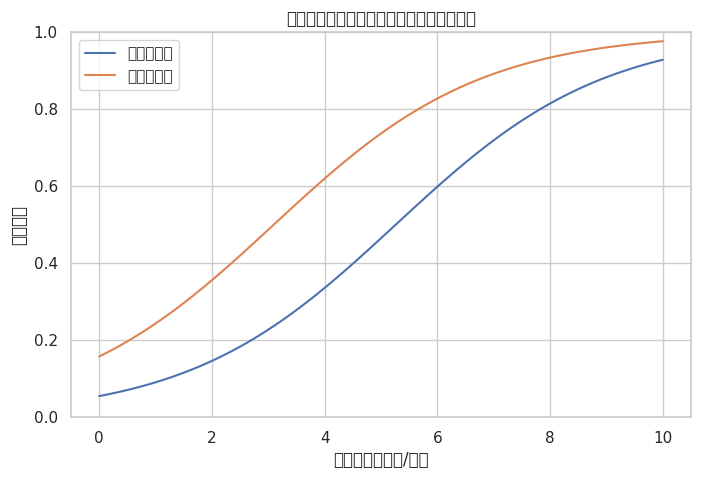

In [20]:
# 学習時間の範囲
hours_grid = np.linspace(0, 10, 100)

# 予備校あり / なし の2パターン
df_pred_no = pd.DataFrame({"study_hours": hours_grid, "prep_course": 0})
df_pred_yes = pd.DataFrame({"study_hours": hours_grid, "prep_course": 1})

# 予測確率
pred_no = logit_result.predict(df_pred_no)
pred_yes = logit_result.predict(df_pred_yes)

plt.figure(figsize=(8,5))
plt.plot(hours_grid, pred_no, label="予備校なし")
plt.plot(hours_grid, pred_yes, label="予備校あり")
plt.xlabel("学習時間（時間/日）")
plt.ylabel("合格確率")
plt.title("ロジスティック回帰による合格確率の予測")
plt.ylim(0, 1)
plt.legend()
plt.show()


### 6.6 ミニ演習：ロジスティック回帰

1. 上のデータ生成過程で、予備校の効果を小さくしたり大きくしたり（係数を変える）して、結果のオッズ比や合格確率のカーブがどう変化するかを確かめてください。
2. 説明変数として `study_hours` の 2 乗項（`I(study_hours ** 2)`）を追加したモデルを推定し、曲線的な関係が生じるかどうかを確認してみましょう。
3. `passed` を予測するシンプルなルール（例：学習時間が 5 時間以上なら 1 など）を自分で考え、ロジスティック回帰モデルと比較して、どちらがどのような意味で優れていると言えるかをコメントしてみてください。

## 7. 時系列分析（Time Series Analysis）

ここでは、`statsmodels` の時系列モジュールを用いて、
簡単な **ARIMA モデル** による時系列解析と予測を体験します。

例として、「月次売上データ」を想定したダミーの時系列を作成し、
傾向（トレンド）と季節性を持つデータに対して ARIMA モデルを当ててみます。

### 7.1 ダミーの月次売上データの作成

5年間（60か月）の売上データを作成します。

- ベースライン: 200
- 緩やかな右肩上がりのトレンド
- 12か月周期の季節性
- ランダムノイズ

In [21]:
# 月次データ（日付インデックス）
date_index = pd.date_range(start="2015-01-01", periods=60, freq="M")

# トレンド + 季節性 + ノイズ
trend = np.linspace(0, 50, 60)  # 緩やかな増加
seasonal = 20 * np.sin(2 * np.pi * np.arange(60) / 12)  # 12ヶ月周期
noise = np.random.normal(loc=0, scale=5, size=60)

sales = 200 + trend + seasonal + noise

ts = pd.Series(sales, index=date_index)
ts.name = "sales"

ts.head()


/tmp/ipykernel_5676/1125173020.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_index = pd.date_range(start="2015-01-01", periods=60, freq="M")


2015-01-31    202.080619
2015-02-28    210.183452
2015-03-31    228.669678
2015-04-30    220.513156
2015-05-31    215.267796
Freq: ME, Name: sales, dtype: float64

### 7.2 時系列データの可視化

まず、全期間の売上推移をプロットします。

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22770 (\N{CJK UNIFIED IDEOGRAPH-58F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/

/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22770 (\N{CJK UNIFIED IDEOGRAPH-58F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/

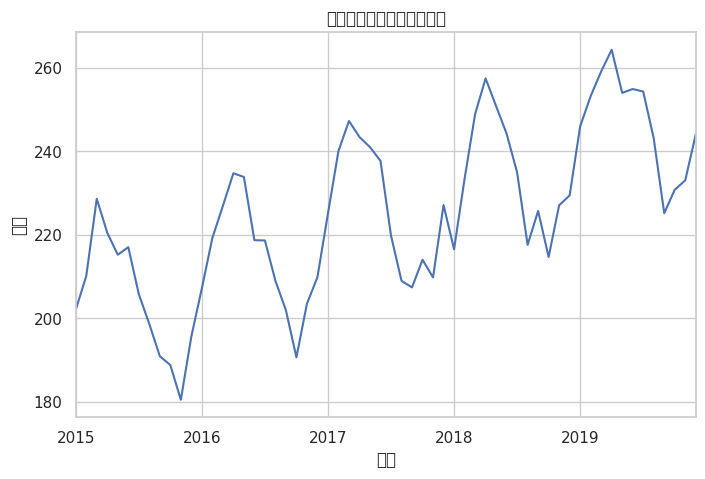

In [22]:
ts.plot()
plt.title("月次売上データ（ダミー）")
plt.xlabel("年月")
plt.ylabel("売上")
plt.show()


### 7.3 ARIMA モデルの推定

`statsmodels.tsa.arima.model` の `ARIMA` クラスを使用します。

ここでは例として、簡単のため ARIMA(1,1,1) モデルを当ててみます。

※ 実務では ACF/PACF や情報量基準（AIC, BIC）などを用いて次数を選びます。

In [23]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA(1,1,1) モデルの当てはめ
arima_model = ARIMA(ts, order=(1, 1, 1))
arima_result = arima_model.fit()

arima_result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -218.618
Date:                Mon, 08 Dec 2025   AIC                            443.237
Time:                        09:30:57   BIC                            449.470
Sample:                    01-31-2015   HQIC                           445.670
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4728      0.527      0.897      0.370      -0.560       1.506
ma.L1         -0.2341      0.576     -0.406      0.685      -1.364       0.896
sigma2        96.7061     25.965      3.724      0.000      45.815     147.597
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.74   Prob(JB):                         0.28
Heteroskedasticity (H):               1.19   Skew:                             0.08
Prob(H) (two-sided):                  0.70   Kurtosis:                         2.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 7.4 予測と将来値のプロット

推定した ARIMA モデルを使って、
観測期間の続きの 12か月分を予測し、元のデータと合わせて可視化します。

/tmp/ipykernel_5676/3155465780.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthEnd(),
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22770 (\N{CJK UNIFIED IDEOGRAPH-58F2}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/katzkawai/jupyterlite-tutorials/.venv/lib/python3.11/site-packa

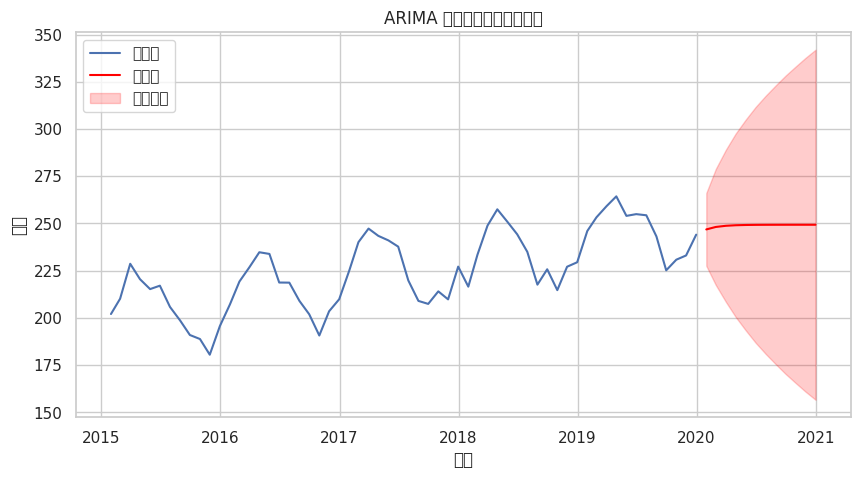

In [24]:
# 予測期間（12ヶ月先まで）
n_forecast = 12
forecast_result = arima_result.get_forecast(steps=n_forecast)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# 結合してプロット
plt.figure(figsize=(10, 5))
plt.plot(ts.index, ts, label="観測値")

forecast_index = pd.date_range(start=ts.index[-1] + pd.offsets.MonthEnd(),
                               periods=n_forecast, freq="M")

plt.plot(forecast_index, forecast_mean, label="予測値", color="red")

# 予測区間の帯
plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color="red", alpha=0.2, label="予測区間")

plt.xlabel("年月")
plt.ylabel("売上")
plt.title("ARIMA モデルによる売上予測")
plt.legend()
plt.show()


### 7.5 ミニ演習：時系列モデル

1. ARIMA モデルの次数 `(p, d, q)` を変えてみて、AIC や BIC の値がどのように変化するかを確認してみてください。
2. 季節性をより強くする、または周期を変える（例：6ヶ月周期にする）などしてダミーデータを作り直し、どのようなモデルがよさそうか考察してみましょう。
3. 予測期間を 24か月に延ばした場合、予測区間の幅がどのように変化するかを確認し、「先の将来ほど予測が不確実になる」という直感と照らし合わせてコメントしてみてください。